<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/AirfoilS809_SAmodel_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install google-auth
from google.colab import auth
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read the data set -  Airfoil S809
df1 = pd.read_csv("/content/drive/MyDrive/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/data_set3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/data_set4.csv")

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from copy import deepcopy
from tensorflow.keras.callbacks import ModelCheckpoint
import logging


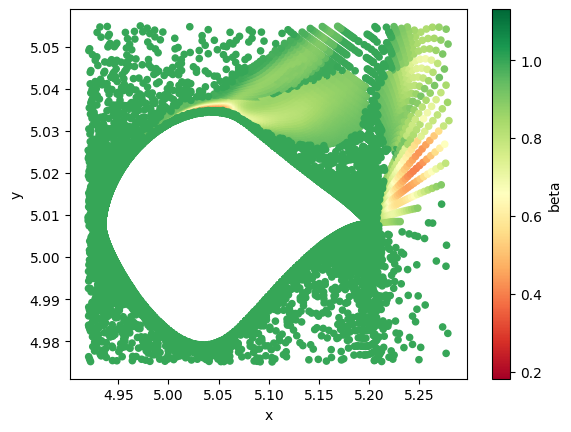

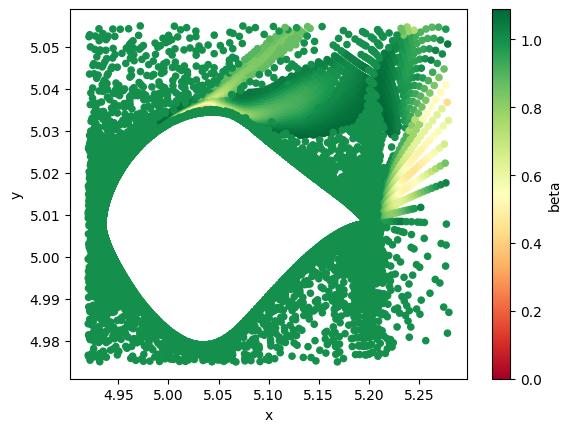

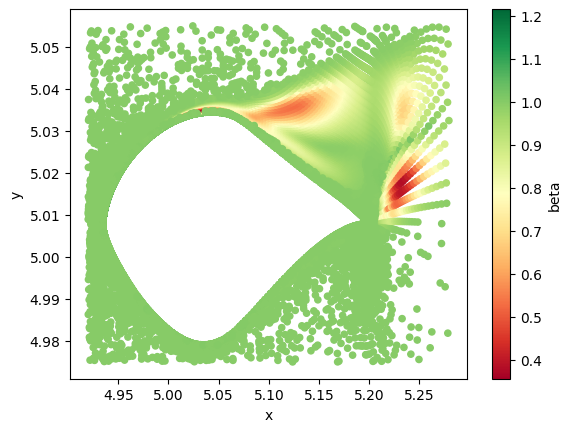

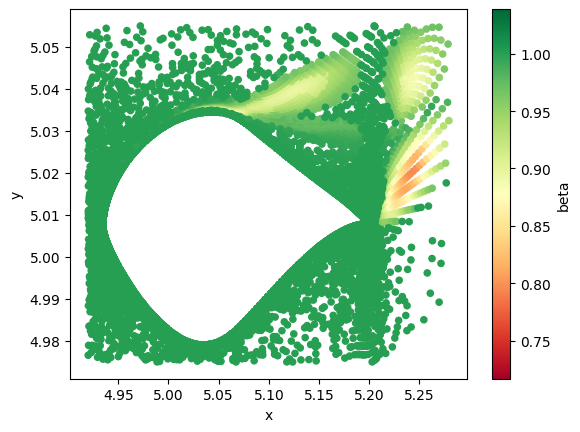

In [5]:
# Combine data
frames = [df1, df2, df3, df4]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  # #####################################################################
  # # Cleaning the beta field in the wake region
  # for k in range(len(xc)):
  #   if xc[k] >= 5.2 and xc[k] <= 5.3:
  #     if yc[k] >= 5.00 and yc[k] <= 4.96:
  #       b2.append(b[k])

  # for j in range(len(xc)):
  #   if xc[j] > 5.15 or yc[j]>5.04:
  #     b[j] = np.mean(b2)

  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.28:
      if yc[i]>=4.975 and yc[i]<=5.055:
        # if (b[i]<0.995) | (b[i]>1.005):
          x1.append(xc[i])
          y1.append(yc[i])
          b1.append(b[i])
          f1.append(ff1[i])
          f2.append(ff2[i])
          f3.append(ff3[i])
          f4.append(ff4[i])
          f5.append(ff5[i])
          f6.append(ff6[i])
        # else:
        #   nnn = np.random.uniform(0,1)
        #   if nnn < 0.10:
        #     x1.append(xc[i])
        #     y1.append(yc[i])
        #     b1.append(b[i])
        #     f1.append(ff1[i])
        #     f2.append(ff2[i])
        #     f3.append(ff3[i])
        #     f4.append(ff4[i])
        #     f5.append(ff5[i])
        #     f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }




  cf = pd.DataFrame(modified_data)
  # Data for beta>1.005 or beta<0.995
  s1 = cf[(cf['beta'] < 0.995) | (cf['beta'] > 1.005)]
  s2 = cf[(cf['beta'] >= 0.995) & (cf['beta'] <= 1.005)]


  s3 = s2.sample(frac=0.20, random_state=1)
  df_filtered = pd.concat([s1, s3], ignore_index=True)

  # df_filtered.shape[0], s1.shape[0], s2.shape[0], s3.shape[0]

  ax = df_filtered.plot.scatter(x='x',
                      y='y',
                      c='beta',
                      colormap='RdYlGn')

  ff.append(df_filtered)

  # # #####################################################################
  # # Plotting cleaned data
  # ################################
  # nx = []
  # ny = []
  # nb = []


  # # Filter data for the specified range of coordinates
  # for i in range(len(xc)):
  #   if xc[i]>=4.9 and xc[i]<=5.3:
  #     if yc[i]>=4.925 and yc[i]<=5.075:
  #       nx.append(xc[i])
  #       ny.append(yc[i])
  #       nb.append(b[i])

  # # Create a scatter plot
  # plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  # plt.colorbar(label='Beta Field')
  # plt.xlabel('X Coordinate')
  # plt.ylabel('Y Coordinate')
  # plt.title('Domain for training')
  # plt.show()
###############################################################################

df = pd.concat(ff)


# # Data for beta>1.02 or beta<0.98
# df_filtered = df[(df['beta'] < 0.995) | (df['beta'] > 1.005)]

# df_filtered = df[df['beta'] != 1.0]

# df_filtered = df


<Axes: xlabel='feature6', ylabel='Density'>

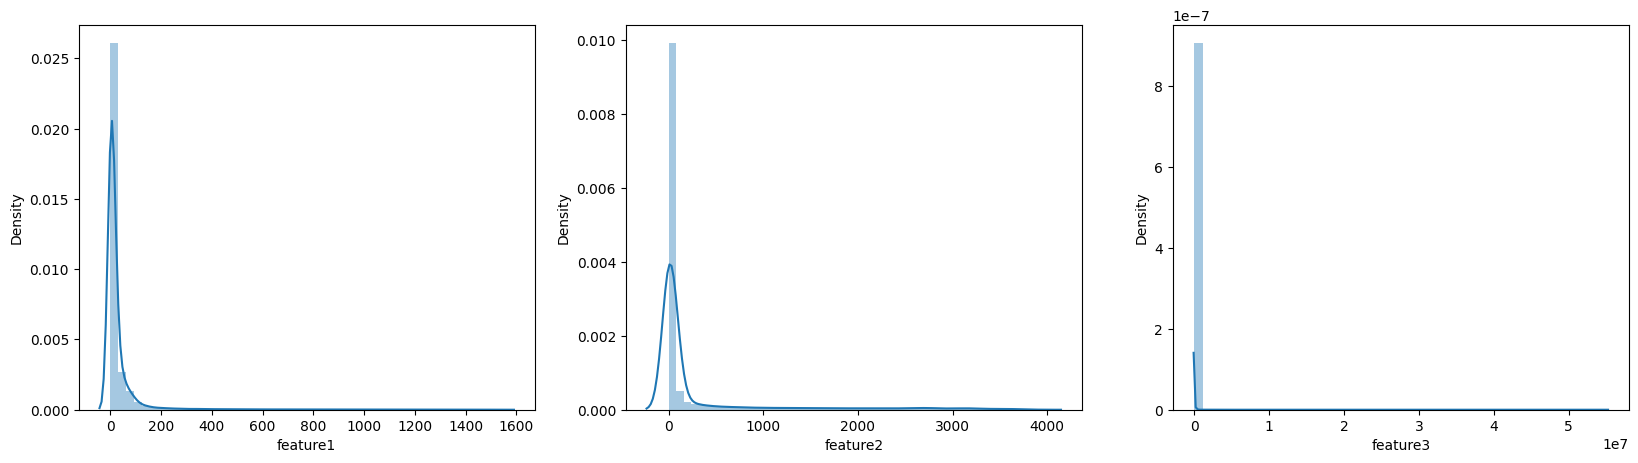

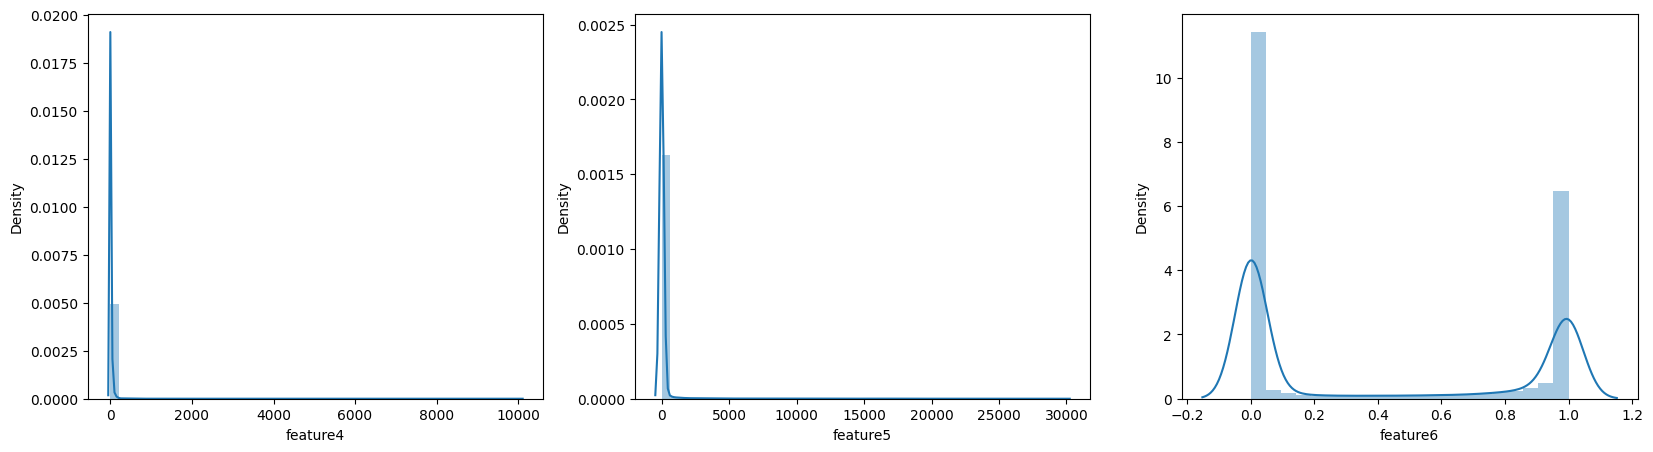

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




# Preprocess Features
df1 = df.drop(['x','y','beta'],axis=1)
df2 = df.drop(['x','y','feature1','feature2','feature3','feature4','feature5','feature6'],axis=1)



## Features with a few outliers and very large range are --> 3,4 and 5
# df1 = df1[df1['feature2'] < 100]
# df1 = df1[df1['feature3'] < 100.0]
# df1 = df1[(df1['feature5'] > 0) & (df1['feature5'] < 60000.0)]

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature1'])
plt.subplot(1,3,2)
sns.distplot(df1['feature2'])
plt.subplot(1,3,3)
sns.distplot(df1['feature3'])
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature4'])
plt.subplot(1,3,2)
sns.distplot(df1['feature5'])
plt.subplot(1,3,3)
sns.distplot(df1['feature6'])

In [ ]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# # # Load the data into a pandas DataFrame
# # df = pd.read_excel(r'C:\Users\adhar\Desktop\Ni_Fatigue_mod.xlsx')

# # Separate features and target variable
# X = df.drop('log10(da/dN)', axis=1)  # Features
# y = df['log10(da/dN)']                # Target variable

# # Get the feature names before converting X to a NumPy array
# feature_names = X.columns.tolist()

# print("Feature Names:", feature_names)

# # Convert X to a NumPy array
# X = X.values

# # Convert y to a NumPy array
# y = y.values

# Split the data into training, validation, and test sets
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

# # Delete temporary variables
# del X_, y_

n = X_train.shape[1]    # Number of features

for i in range(n):
    print(f"Feature {i+1} Max, Min pre normalization: {np.max(X_train[:, i]): 0.2f}, {np.min(X_train[:, i]): 0.2f}")

norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X_train)  # learns mean, variance
X_train_n = norm_l(X_train)
# X_train_n = X_train



for i in range(n):
    print(f"Feature {i+1} Max, Min post normalization: {np.max(X_train_n[:, i]): 0.2f}, "
          f"{np.min(X_train_n[:, i]): 0.2f}")
    # X_train_n[:,i] = X_train_n[:,i]/(np.max(X_train_n[:, i]))
    # X_test_n[:,i] = X_test_n[:,i]/(np.max(X_train_n[:, i]))
    # X_cv_n[:,i] = X_cv_n[:,i]/(np.max(X_train_n[:, i]))
X_cv_n = norm_l(X_cv)
X_test_n = norm_l(X_test)

# X_cv_n = X_cv
# X_test_n = X_test

# Define a ModelCheckpoint callback to save the model
checkpoint_filepath = r'/content/drive/MyDrive/best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Define the main model without any regularization
# main_model = Sequential([
#     tf.keras.Input(shape=(n,)),
#     Dense(units=9, activation='relu'),
#     Dropout(0.10),
#     Dense(units=1200, activation='relu'),
#     Dropout(0.10),
#     Dense(units=1, activation='linear')
# ])

